# Assignment 2: 





In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score,f1_score,recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB


In [8]:
# ignore warnings 
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None # default='warn'

acknowledgement:TMDB_Classification-checkpoint.ipynb were used as the backbone of this file



First, we read in the data into a pandas DataFrame.




In [9]:
# Read data into pandas DataFrame
train = pd.read_csv("TMDB_train.csv")
evaluate = pd.read_csv("TMDB_evaluate.csv")
test = pd.read_csv("TMDB_test.csv")

print(train.shape)
print(evaluate.shape)
print(test.shape)

(100000, 44)
(20000, 44)
(20000, 42)


Transform Language text data to numerical code

In [10]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame containing the data

# Combine all relevant columns into one list
languageSet = pd.concat([train['original_language'], evaluate['original_language'], test['original_language']])

# Fit LabelEncoder on the combined data
label_encoder = LabelEncoder()
label_encoder.fit(languageSet)

# Transform each dataset individually
train['original_language'] = label_encoder.transform(train['original_language'])
evaluate['original_language'] = label_encoder.transform(evaluate['original_language'])
test['original_language'] = label_encoder.transform(test['original_language'])


label_encoder.classes_


array(['ab', 'af', 'ak', 'am', 'ar', 'as', 'ay', 'az', 'be', 'bg', 'bi',
       'bm', 'bn', 'bo', 'bs', 'ca', 'cn', 'cs', 'cy', 'da', 'de', 'dv',
       'dz', 'el', 'en', 'eo', 'es', 'et', 'eu', 'fa', 'ff', 'fi', 'fo',
       'fr', 'fy', 'ga', 'gd', 'gl', 'gu', 'ha', 'he', 'hi', 'hr', 'ht',
       'hu', 'hy', 'id', 'ie', 'is', 'it', 'iu', 'ja', 'jv', 'ka', 'kk',
       'kl', 'km', 'kn', 'ko', 'ks', 'ku', 'kw', 'ky', 'la', 'lb', 'li',
       'ln', 'lo', 'lt', 'lv', 'mg', 'mh', 'mi', 'mk', 'ml', 'mn', 'mo',
       'mr', 'ms', 'mt', 'my', 'nb', 'ne', 'nl', 'nn', 'no', 'ny', 'or',
       'os', 'pa', 'pl', 'ps', 'pt', 'qu', 'rm', 'ro', 'ru', 'rw', 'sa',
       'sc', 'sh', 'si', 'sk', 'sl', 'sn', 'so', 'sq', 'sr', 'st', 'sv',
       'sw', 'ta', 'te', 'tg', 'th', 'tk', 'tl', 'tn', 'tr', 'tt', 'tw',
       'uk', 'ur', 'uz', 'vi', 'wo', 'xh', 'xx', 'yi', 'yo', 'zh', 'zu'],
      dtype=object)

In [5]:
# # Seems tht Taglines are missing for some movies
# df[df.isna().any(axis=1)]

# # FillNa with empty stering
# df['tagline'] = df['tagline'].fillna('')
# # replace Nan with empty String
# # df.replace(" ", pd.NA, inplace=True)

In [11]:
no_text_features = ['release_year','runtime','budget','revenue','adult','original_language','popularity',
                        'genre_Action','genre_Adventure','genre_Animation','genre_Comedy','genre_Crime','genre_Documentary','genre_Drama','genre_Family',
                        'genre_Fantasy','genre_History','genre_Horror','genre_Music','genre_Mystery','genre_Romance','genre_Science Fiction',
                        'genre_TV Movie','genre_Thriller','genre_War','genre_Western','product_of_Canada','product_of_France','product_of_Germany',
                        'product_of_India','product_of_Italy','product_of_Japan','product_of_Spain','product_of_UK','product_of_USA','product_of_other_countries',
                        'vote_count']
text_features = ['title','overview','tagline','production_companies']
Label = ['rate_category', 'average_rate']

In [13]:
X_train_without_text = train[no_text_features]
X_train_text = train[text_features]
y_train = train['rate_category']
y_train_numeric = train['average_rate']

X_eval_without_text = evaluate[no_text_features]
X_eval_text = evaluate[text_features]
y_eval = evaluate['rate_category']
y_eval_numeric = evaluate['average_rate']

X_test_without_text = test[no_text_features]
X_test_text = test[text_features]

print(X_train_without_text.shape)
print(X_train_text.shape)

(100000, 37)
(100000, 4)


# Baseline (ZERO-Rule)


In [14]:
# Zero-R baseline classify everything as the most common class in the training dataset
zeroR= DummyClassifier(strategy="most_frequent")
zeroR.fit(X_train_without_text, y_train)
y_pred = zeroR.predict(X_eval_without_text)
accuracy = accuracy_score(y_eval, y_pred)
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.00      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.00      0.00      0.00      2791
           5       0.00      0.00      0.00      1657

    accuracy                           0.27     20000
   macro avg       0.05      0.17      0.07     20000
weighted avg       0.07      0.27      0.12     20000



# Without Text


In [17]:

import time

# List for Confusion Matrix
y_preds =[]

def runClassifiers(X_train,y_train,X_eval,y_eval,type):
    # Step 4: Train and evaluate classifiers
    classifiers = {
        "Multinomial Naive Bayes": MultinomialNB(),
        # "GaussianNB" :GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(),
        # Tested 1000,5000,500, 300, still not converging at 5000, changing max_iter to 100 does not seem to reduce accuracy by much but save time
        "Logistic Regression": LogisticRegression(max_iter=300),
        "Multi-Layer Perceptron": MLPClassifier(max_iter=300),
        "KNN":KNeighborsClassifier(n_neighbors=5)
    }

    for name, classifier in classifiers.items():
        start =time.time()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_eval)
        accuracy = accuracy_score(y_eval, y_pred)
        print(f"{name} Accuracy: {accuracy}")
        print(classification_report(y_eval, y_pred))
        end=time.time()
        print(f"{name} Time Taken: {end - start} seconds")
        print("########################################")
        
        #################################################
        if type =="No Text" :
            if name == "Multinomial Naive Bayes":
                y_pred_mnb_no_text = y_preds.append(y_pred)
            elif name == "Decision Tree":
                y_pred_dt_no_text = y_preds.append(y_pred)
            elif name == "Logistic Regression":
                y_pred_lr_no_text = y_preds.append(y_pred)
            elif name == "Multi-Layer Perceptron":
                y_pred_mlp_no_text = y_preds.append(y_pred)
        elif type == "BoW Text":
            if name == "Multinomial Naive Bayes":
                y_pred_mnb_bow_text = y_preds.append(y_pred)
            elif name == "Decision Tree":
                y_pred_dt_bow_text = y_preds.append(y_pred)
            elif name == "Logistic Regression":
                y_pred_lr_bow_text = y_preds.append(y_pred)
            elif name == "Multi-Layer Perceptron":
                y_pred_mlp_bow_text = y_preds.append(y_pred)
        elif type == "BoW All":
                if name == "Multinomial Naive Bayes":
                    y_pred_mnb_bow_all = y_preds.append(y_pred)
                elif name == "Decision Tree":
                    y_pred_dt_bow_all = y_preds.append(y_pred)
                elif name == "Logistic Regression":
                    y_pred_lr_bow_all = y_preds.append(y_pred)
                elif name == "Multi-Layer Perceptron":
                    y_pred_mlp_bow_all = y_preds.append(y_pred)
        elif type == "TF-IDF Text":
                if name == "Multinomial Naive Bayes":
                    y_pred_mnb_tfidf_text = y_preds.append(y_pred)
                elif name == "Decision Tree":
                    y_pred_dt_tfidf_text = y_preds.append(y_pred)
                elif name == "Logistic Regression":
                    y_pred_lr_tfidf_text = y_preds.append(y_pred)
                elif name == "Multi-Layer Perceptron":
                    y_pred_mlp_tfidf_text = y_preds.append(y_pred)
        elif type == "TF-IDF All":
                if name == "Multinomial Naive Bayes":
                    y_pred_mnb_tfidf_all = y_preds.append(y_pred)
                elif name == "Decision Tree":
                    y_pred_dt_tfidf_all = y_preds.append(y_pred)
                elif name == "Logistic Regression":
                    y_pred_lr_tfidf_all = y_preds.append(y_pred)
                elif name == "Multi-Layer Perceptron":
                    y_pred_mlp_tfidf_all = y_preds.append(y_pred)
                        
# without text eval
runClassifiers(X_train_without_text,y_train,X_eval_without_text,y_eval, "No Text")




Decision Tree Accuracy: 0.6574
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      2184
           1       0.63      0.63      0.63      2829
           2       0.66      0.67      0.67      5119
           3       0.69      0.69      0.69      5420
           4       0.64      0.62      0.63      2791
           5       0.64      0.63      0.64      1657

    accuracy                           0.66     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.66      0.66      0.66     20000

Decision Tree Time Taken: 0.8488292694091797 seconds
########################################


# Feature_Selection (Non-Text Features)

In [10]:
# Initialize classifiers
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed
}

# Define the number of features to select
k_values = [20, 10, 5,3,1]



for k in k_values:
    print(f"\nTop {k} Features:")
    
    # Initialize SelectKBest with ANOVA F-value as the scoring function
    selector = SelectKBest(score_func=f_classif, k=k)
    
    # Fit selector to training data and transform X1_train
    X1_train_selected = selector.fit_transform(X_train_without_text, y_train)
    
    # Get the indices of the selected features
    selected_feature_indices = selector.get_support(indices=True)
    
    # Get the names of the selected features
    selected_feature_names = X_train_without_text.columns[selected_feature_indices]
    print("Selected Features:", selected_feature_names)
    
    # Evaluate classifiers using the selected features
    for name, classifier in classifiers.items():
        # Train classifier on selected features
        classifier.fit(X1_train_selected, y_train)
        
        # Transform X1_test using the same selected features
        X_eval_selected = X_eval_without_text.iloc[:, selected_feature_indices]
        
        # Predict labels for X_eval
        y_pred = classifier.predict(X_eval_selected)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_eval, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")



Top 20 Features:
Selected Features: Index(['release_year', 'runtime', 'budget', 'revenue', 'adult', 'popularity',
       'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_History', 'genre_Horror',
       'genre_Music', 'genre_Romance', 'genre_Thriller', 'genre_Western',
       'product_of_Japan', 'vote_count'],
      dtype='object')
Multinomial Naive Bayes Accuracy: 0.1172
Gaussian Naive Bayes Accuracy: 0.1224
Logistic Regression Accuracy: 0.2721
Decision Tree Accuracy: 0.6411
KNN Accuracy: 0.4064

Top 10 Features:
Selected Features: Index(['release_year', 'runtime', 'budget', 'adult', 'genre_Comedy',
       'genre_Documentary', 'genre_Drama', 'genre_Horror', 'genre_Music',
       'vote_count'],
      dtype='object')
Multinomial Naive Bayes Accuracy: 0.1300
Gaussian Naive Bayes Accuracy: 0.1263
Logistic Regression Accuracy: 0.2728
Decision Tree Accuracy: 0.6052
KNN Accuracy: 0.4063

Top 5 Features:
Selected Features: In

# With Text (BOW)


In [11]:
#Load NPZ sparse matrix to normal matrix that can be used for testing
X_train_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/train_concat_bow.npz')
X_eval_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/eval_concat_bow.npz')


# BOW eval
runClassifiers(X_train_concat_bow,y_train,X_eval_concat_bow,y_eval, "BoW Text")


Multinomial Naive Bayes Accuracy: 0.27645
              precision    recall  f1-score   support

           0       0.22      0.13      0.16      2184
           1       0.23      0.13      0.17      2829
           2       0.30      0.38      0.33      5119
           3       0.32      0.34      0.33      5420
           4       0.22      0.17      0.19      2791
           5       0.23      0.37      0.28      1657

    accuracy                           0.28     20000
   macro avg       0.25      0.25      0.25     20000
weighted avg       0.27      0.28      0.27     20000

Multinomial Naive Bayes Time Taken: 0.051596879959106445 seconds
########################################
Decision Tree Accuracy: 0.6171
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      2184
           1       0.60      0.58      0.59      2829
           2       0.63      0.65      0.64      5119
           3       0.64      0.65      0.65      5420
       

# With Text (TFIDF)

In [12]:
# Load tfidf sparse matrix
X_train_concat_tfidf = scipy.sparse.load_npz('TMDB_text_features_tfidf/train_concat_tfidf.npz')
X_eval_concat_tfidf = scipy.sparse.load_npz('TMDB_text_features_tfidf/eval_concat_tfidf.npz')

# TFIDF eval
runClassifiers(X_train_concat_tfidf,y_train,X_eval_concat_tfidf,y_eval, "TF-IDF Text" )

Multinomial Naive Bayes Accuracy: 0.2959
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.30      0.42      0.35      5119
           3       0.30      0.65      0.41      5420
           4       0.30      0.01      0.02      2791
           5       0.29      0.15      0.20      1657

    accuracy                           0.30     20000
   macro avg       0.28      0.20      0.16     20000
weighted avg       0.28      0.30      0.22     20000

Multinomial Naive Bayes Time Taken: 0.04437828063964844 seconds
########################################
Decision Tree Accuracy: 0.61455
              precision    recall  f1-score   support

           0       0.59      0.56      0.58      2184
           1       0.59      0.58      0.59      2829
           2       0.63      0.65      0.64      5119
           3       0.64      0.66      0.65      5420
        

# All Features with vectorized text concatenated (BOW)

In [13]:
X_train_concat_bow_df = pd.DataFrame.sparse.from_spmatrix(X_train_concat_bow)
X_eval_concat_bow_df = pd.DataFrame.sparse.from_spmatrix(X_eval_concat_bow)
# Make sure column names are strings
X_train_concat_bow_df.columns = X_train_concat_bow_df.columns.astype(str)
X_eval_concat_bow_df.columns = X_eval_concat_bow_df.columns.astype(str)
if (len(X_train_concat_bow_df) != len(X_train_without_text) )or (len(X_eval_concat_bow_df) != len(X_eval_without_text)):
    raise ValueError("Sparse matrix and CSV DataFrame do not have the same number of rows!")

# combine text with non-text
X_train_combined = pd.concat([X_train_without_text, X_train_concat_bow_df], axis=1)
X_eval_combined = pd.concat([X_eval_without_text, X_eval_concat_bow_df], axis=1)
X_train_combined.shape



runClassifiers(X_train_combined,y_train,X_eval_combined,y_eval, "BoW All")

Multinomial Naive Bayes Accuracy: 0.1172
              precision    recall  f1-score   support

           0       0.12      0.99      0.21      2184
           1       0.07      0.00      0.01      2829
           2       0.28      0.01      0.02      5119
           3       0.49      0.01      0.02      5420
           4       0.35      0.01      0.03      2791
           5       0.04      0.02      0.02      1657

    accuracy                           0.12     20000
   macro avg       0.22      0.17      0.05     20000
weighted avg       0.28      0.12      0.04     20000

Multinomial Naive Bayes Time Taken: 0.8732998371124268 seconds
########################################
Decision Tree Accuracy: 0.66225
              precision    recall  f1-score   support

           0       0.63      0.64      0.63      2184
           1       0.63      0.62      0.62      2829
           2       0.67      0.67      0.67      5119
           3       0.70      0.70      0.70      5420
         

# All Features with vectorized text concatenated (TFIDF)

In [14]:
X_train_concat_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_train_concat_tfidf)
X_eval_concat_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_eval_concat_tfidf)
# Make sure column names are stings
X_train_concat_tfidf_df.columns = X_train_concat_tfidf_df.columns.astype(str)
X_eval_concat_tfidf_df.columns = X_eval_concat_tfidf_df.columns.astype(str)
if (len(X_train_concat_tfidf_df) != len(X_train_without_text) )or (len(X_eval_concat_tfidf_df) != len(X_eval_without_text)):
    raise ValueError("Sparse matrix and CSV DataFrame do not have the same number of rows!")

# combine text with non-text
X_train_combined = pd.concat([X_train_without_text, X_train_concat_tfidf_df], axis=1)
X_eval_combined = pd.concat([X_eval_without_text, X_eval_concat_tfidf_df], axis=1)
X_train_combined.shape
# X_eval_combined.head(5)


runClassifiers(X_train_combined,y_train,X_eval_combined,y_eval, "TF-IDF All")

Multinomial Naive Bayes Accuracy: 0.1172
              precision    recall  f1-score   support

           0       0.12      0.99      0.21      2184
           1       0.07      0.00      0.01      2829
           2       0.28      0.01      0.02      5119
           3       0.49      0.01      0.02      5420
           4       0.35      0.01      0.03      2791
           5       0.04      0.02      0.02      1657

    accuracy                           0.12     20000
   macro avg       0.22      0.17      0.05     20000
weighted avg       0.28      0.12      0.04     20000

Multinomial Naive Bayes Time Taken: 0.8117766380310059 seconds
########################################
Decision Tree Accuracy: 0.65505
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2184
           1       0.63      0.61      0.62      2829
           2       0.67      0.66      0.67      5119
           3       0.68      0.69      0.69      5420
         

# Confusion Matrix


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


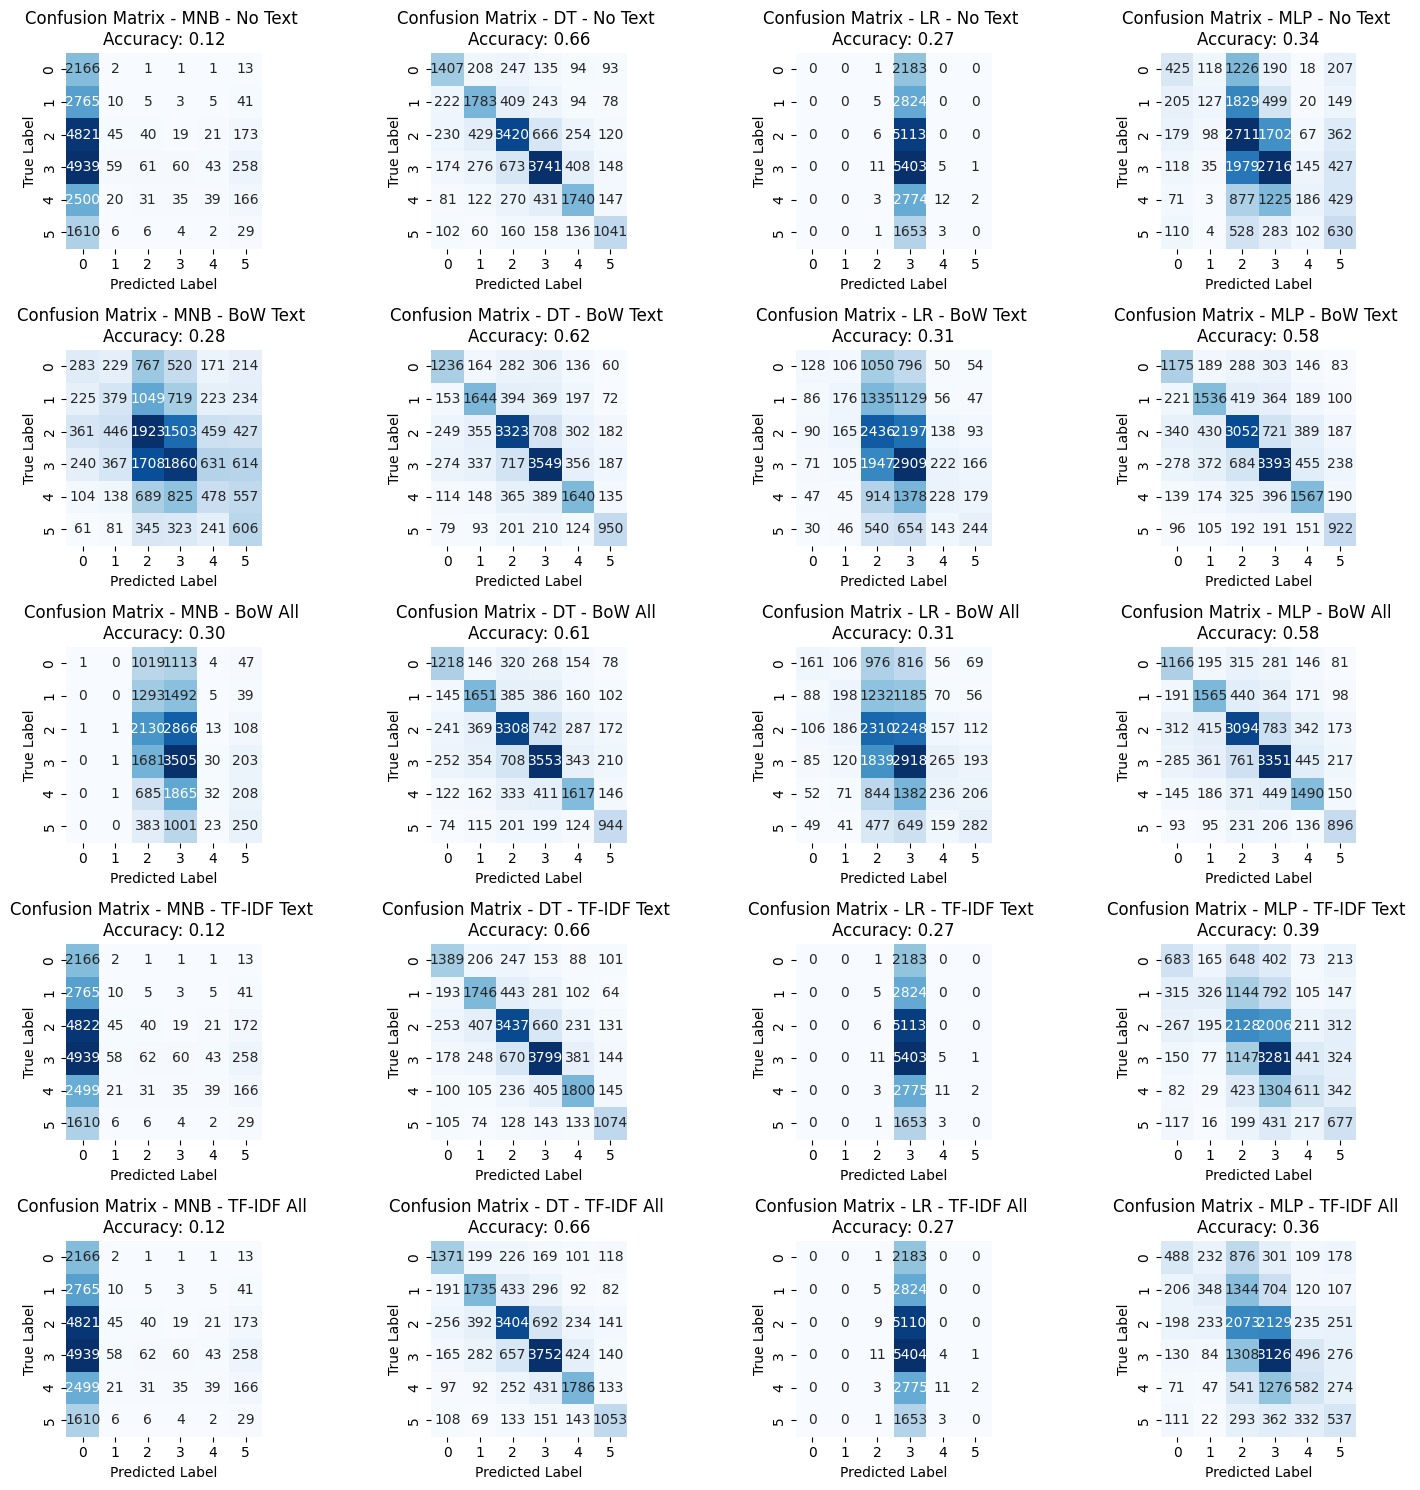

In [17]:
%pip install seaborn
import seaborn as sns


# List of y_pred values
# y_preds = [y_pred_mnb_no_text, y_pred_dt_no_text,y_pred_lr_no_text, y_pred_mlp_no_text,
#            y_pred_mnb_bow_text, y_pred_dt_bow_text,y_pred_lr_bow_text, y_pred_mlp_bow_text, 
#            y_pred_mnb_bow_all, y_pred_dt_bow_all,y_pred_lr_bow_all, y_pred_mlp_bow_all,
#            y_pred_mnb_tfidf_text, y_pred_dt_tfidf_text,y_pred_lr_tfidf_text, y_pred_mlp_tfidf_text,
#            y_pred_mnb_tfidf_all, y_pred_dt_tfidf_all,y_pred_lr_tfidf_all, y_pred_mlp_tfidf_all]

# List of corresponding labels
labels = ['MNB - No Text', 'DT - No Text', 'LR - No Text', 'MLP - No Text',
          'MNB - BoW Text', 'DT - BoW Text', 'LR - BoW Text', 'MLP - BoW Text',
          'MNB - BoW All', 'DT - BoW All', 'LR - BoW All', 'MLP - BoW All',
          'MNB - TF-IDF Text', 'DT - TF-IDF Text', 'LR - TF-IDF Text', 'MLP - TF-IDF Text',
          'MNB - TF-IDF All', 'DT - TF-IDF All', 'LR - TF-IDF All', 'MLP - TF-IDF All']

# Plot confusion matrices for each y_pred
plt.figure(figsize=(15, 15))
for i, (y_pred, label) in enumerate(zip(y_preds, labels)):
    cm = confusion_matrix(y_eval, y_pred)
    accuracy = accuracy_score(y_eval, y_pred)
    plt.subplot(5, 4, i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {label} \nAccuracy: {accuracy:.2f}')

plt.tight_layout()
plt.show()

# Halving the Dataset 

In [20]:
X_train_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/train_concat_bow.npz')
X_eval_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/eval_concat_bow.npz')

X_train_concat_bow_df = pd.DataFrame.sparse.from_spmatrix(X_train_concat_bow)
X_eval_concat_bow_df = pd.DataFrame.sparse.from_spmatrix(X_eval_concat_bow)
# Make sure column names are stings
X_train_concat_bow_df.columns = X_train_concat_bow_df.columns.astype(str)
X_eval_concat_bow_df.columns = X_eval_concat_bow_df.columns.astype(str)
if (len(X_train_concat_bow_df) != len(X_train_without_text) )or (len(X_eval_concat_bow_df) != len(X_eval_without_text)):
    raise ValueError("Sparse matrix and CSV DataFrame do not have the same number of rows!")


X_train_combined = pd.concat([X_train_without_text, X_train_concat_bow_df], axis=1)
X_eval_combined = pd.concat([X_eval_without_text, X_eval_concat_bow_df], axis=1)
X_train_combined.shape


X_train_combined_half = X_train_combined.head(50000)
y_train_half = y_train.head(50000)

runClassifiers(X_train_combined_half,y_train_half,X_eval_combined,y_eval, "")

Decision Tree Accuracy: 0.4769
              precision    recall  f1-score   support

           0       0.44      0.45      0.44      2184
           1       0.43      0.43      0.43      2829
           2       0.49      0.50      0.49      5119
           3       0.53      0.53      0.53      5420
           4       0.45      0.44      0.44      2791
           5       0.45      0.45      0.45      1657

    accuracy                           0.48     20000
   macro avg       0.46      0.46      0.46     20000
weighted avg       0.48      0.48      0.48     20000

Decision Tree Time Taken: 7.949616432189941 seconds
########################################


# Final File for Submission

In [18]:
# X_test_concat_tfidf = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_tfidf/test_concat_tfidf.npz')

# DT trained on data without text features because it's most cost effective in terms of time
DTClf =DecisionTreeClassifier()


DTClf.fit(X_train_without_text, y_train)
y_pred = DTClf.predict(X_test_without_text)

test["rate_category"] = y_pred

result = test[["id", "rate_category"]]
result.to_csv('test_result.csv', index=False)
